In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import plotly.offline as po 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("train.csv")

# 1. Data Understanding

In the following section we will explore the data by looking at descriptive statistics and visualizations, in order to understand our features' distribution, identify outliers, and reveal any data issues (e.g. missing values) that might exist. 

In [3]:
df.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0


In [4]:
print(len(df.Patient_ID.unique())) #Check if Patient_ID can be used as index
df = df.set_index("Patient_ID")

900


In [5]:
df.describe()

,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Deceased
count,900.000000,900.000000,723.000000,900.000000,900.000000,900.000000,900.000000
mean,14305.827778,2.313333,1990.266943,0.380000,0.521111,895.743333,0.614444
std,25418.153900,0.834223,14.523335,0.803247,1.098385,1385.829926,0.486997
min,345.000000,1.000000,1940.000000,0.000000,0.000000,0.000000,0.000000
25%,8203.000000,2.000000,1982.000000,0.000000,0.000000,221.000000,0.000000
50%,13593.500000,3.000000,1992.000000,0.000000,0.000000,405.000000,1.000000
75%,18906.500000,3.000000,1999.500000,0.000000,1.000000,861.250000,1.000000
max,742836.000000,3.000000,2019.000000,6.000000,8.000000,14345.000000,1.000000


These statistics indicate that it suffices to look at `Birthday_Year` and `Medical_Expenses_Family` for potential outliers. The other features do not seem to have any strange values. 

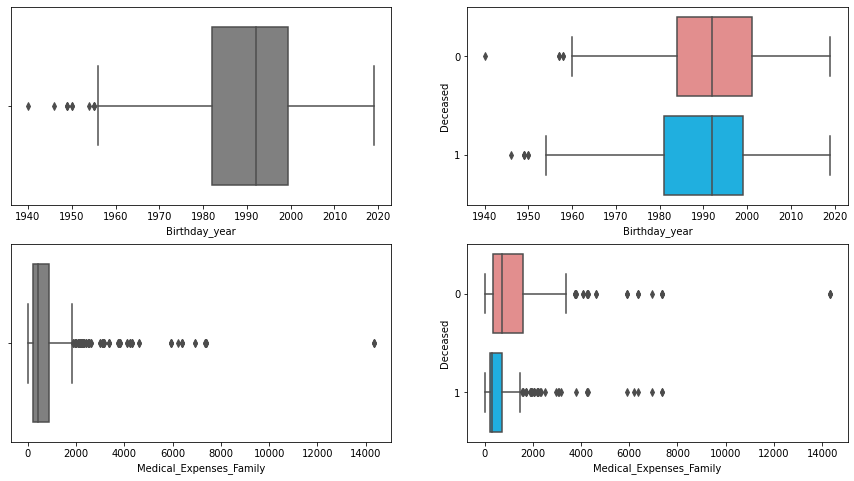

In [6]:
# Boxplot age 
palette = ['lightcoral', 'deepskyblue']

f = plt.figure(figsize=(15, 8))
gs = f.add_gridspec(2,2)

ax = f.add_subplot(gs[0, 0])
sns.boxplot(data=df, x = 'Birthday_year', orient = 'h', color = 'gray')

ax = f.add_subplot(gs[0, 1])
sns.boxplot(data=df, x = 'Birthday_year', y = 'Deceased', orient = 'h', palette = palette)

ax = f.add_subplot(gs[1, 0])
sns.boxplot(data=df, x = 'Medical_Expenses_Family', orient = 'h', color = 'gray')

ax = f.add_subplot(gs[1, 1])
sns.boxplot(data=df, x = 'Medical_Expenses_Family', y = 'Deceased', orient = 'h', palette = palette)

**Interpretation**:
- we can see some (potential) outliers in both features
- the `Age` distribution doesn't seem to be that great at separating the target classes, while the `Medical_Expenses_Family` definitely illustrates some differences 

In [7]:
# Number of Nan values 
df.isna().sum()

Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64

There are a lot of medical tent nan values. Medical tent it is basically the tent where the patient has been cured.. don't know how useful it is.. 


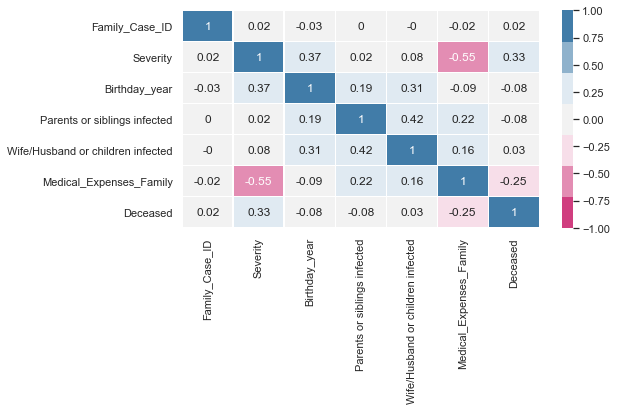

In [8]:
# Creating the correlation matrix 
pearson_corr_matrix=df.corr('pearson').round(decimals=2)
sns.set(rc={'figure.figsize':(8,4)})
sns.heatmap(pearson_corr_matrix,
        xticklabels=pearson_corr_matrix.columns,
        yticklabels=pearson_corr_matrix.columns, 
        annot=True, 
        linewidths=.5, 
        vmin = -1,
        vmax = 1,
        cmap=sns.diverging_palette(-10, 240, sep=70, n=7))


Pretty weird the fact that there's an high negative correlation between medical expenss and severity.. I would have thought the contrary, the most is severe the most on meds you would spend. Normal to see birthday year and severity in positive correlation and the same for parents or sibilings and wife/husband. 

In [9]:
numerical_var = ["Severity","Parents or siblings infected", "Wife/Husband or children infected", "Medical_Expenses_Family"]

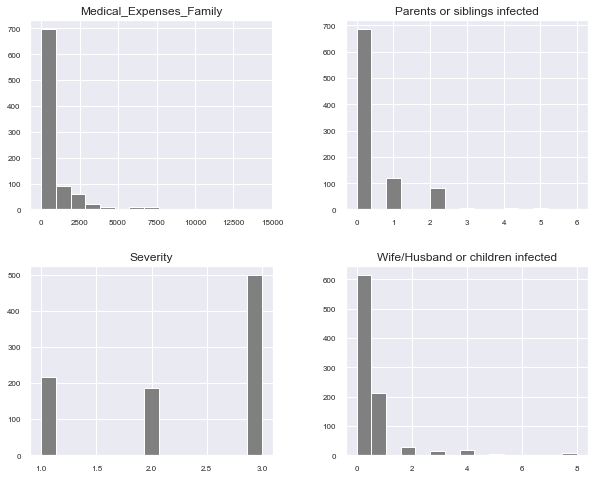

In [10]:
# Histograms for all numeric variables
sns.set(rc={'figure.figsize':(10,8)})
df[numerical_var].hist(bins=15, layout=(2, 2), xlabelsize=8, ylabelsize=8, color = 'gray');

In [11]:
# Family sizes
print(len(df.Family_Case_ID.unique()))
pd.Series(df.Family_Case_ID.value_counts()).value_counts()

675


1    530
2    102
3     24
4     10
7      3
6      3
5      3
Name: Family_Case_ID, dtype: int64

Text(0, 0.5, 'Frequency')

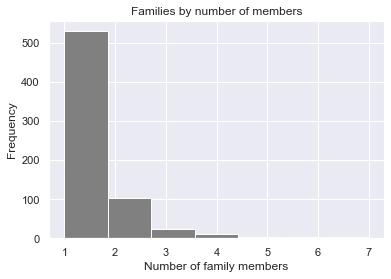

In [12]:
# Plotting how big the family are, most of them just 1/2
families = df.groupby(["Family_Case_ID"])["Family_Case_ID"].count().reset_index(name='count').sort_values(by='count')

sns.set(rc={'figure.figsize':(6,4)})
ax = families.plot(x='Family_Case_ID', y ='count' , kind="hist",legend= False, title = "Families by number of members",bins=7, color = 'gray')
ax.set_xlabel("Number of family members")
ax.set_ylabel("Frequency")

In [13]:
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color=palette[1])
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color=palette[0])
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color=palette[1])
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color=palette[0])
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")

    plt.show()

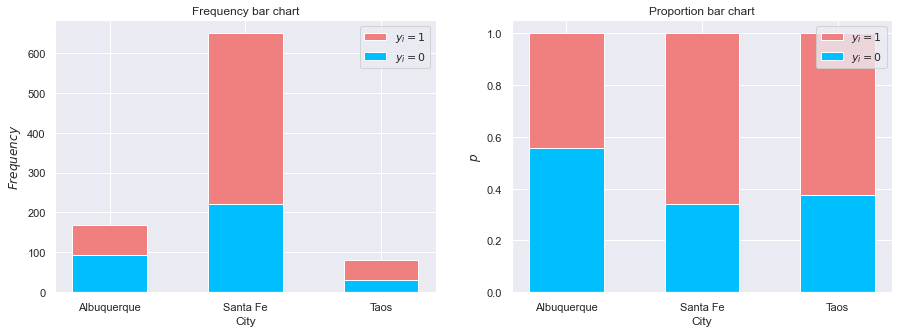

In [14]:
bar_charts_categorical(df, 'City', 'Deceased')

In [15]:
# Create gender 
df['Name'].str.rsplit(' ', n=2, expand=True)[0].value_counts()
gender = {'Mr.':"M",'Ms.':"F",'Master':"M",'Miss':"F"}
df['Name'] = df['Name'].str.rsplit(' ', n=0, expand=True)
df['Name'] = [gender[item] for item in df['Name']]
df.rename(columns = {'Name':'Gender'},inplace=True)

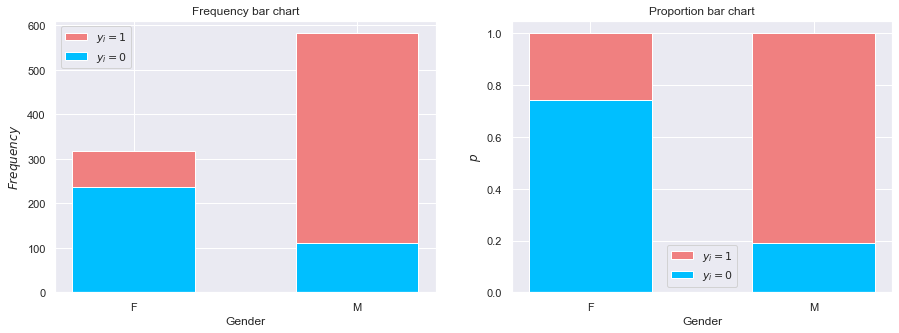

In [16]:
bar_charts_categorical(df, 'Gender','Deceased')

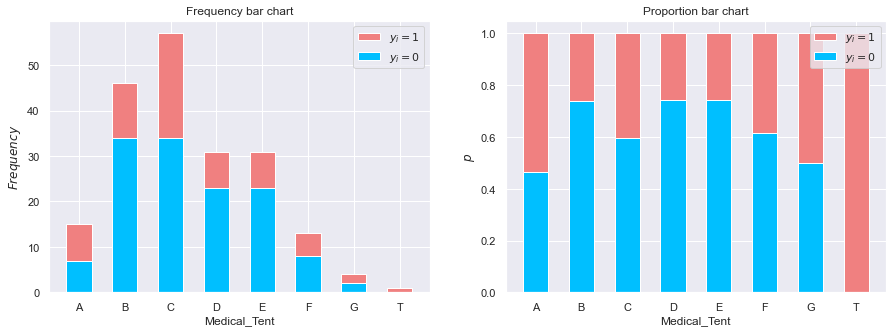

In [17]:
bar_charts_categorical(df, 'Medical_Tent','Deceased')

It seems like certain tents have way more deceased people than others. Maybe we can use this information for the feature engineering.

# 2. Data Preparation

## 2.1 NaN values elimination

In [18]:
# check NaN values 
df.isnull().sum()

Family_Case_ID                         0
Severity                               0
Gender                                 0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64

In [19]:
# check unique medical tent values 
df['Medical_Tent'].unique()

array([nan, 'F', 'B', 'A', 'E', 'C', 'D', 'G', 'T'], dtype=object)

It might make sense to treat NaN values as an extra category, as this could potentially hold information about the target variable.<br>
So let's replace NaN with "n/a". 

In [20]:
df['Medical_Tent'] = df['Medical_Tent'].replace(np.nan, 'n/a', regex=True)

In [21]:
# need to decide what to do with these..
df[df['Birthday_year'].isna()]

,Family_Case_ID,Severity,Gender,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
Patient_ID,,,,,,,,,,
1,4696,3,F,NaN,0,0,225,n/a,Santa Fe,1
6,17598,2,M,NaN,0,0,0,n/a,Santa Fe,1
10,14392,3,F,NaN,1,1,626,F,Albuquerque,0
15,6507,3,F,NaN,0,0,217,n/a,Taos,0
16,19174,3,M,NaN,0,0,211,n/a,Santa Fe,1
...,...,...,...,...,...,...,...,...,...,...
870,3539,3,M,NaN,0,0,423,n/a,Santa Fe,1
871,4275,3,M,NaN,0,0,202,n/a,Albuquerque,1
872,11524,1,M,NaN,0,0,0,n/a,Santa Fe,1


There are too many instances with a missing `Birthday_year`. So instead of removing them, we will replace the NaN values with -1. 

In [22]:
df['Birthday_year'] = df['Birthday_year'].replace(np.nan, -1)

In [23]:
# check missing city 
df[df['City'].isna()]
# since we only have two records, we can just drop them 
df = df[df['City'].notna()]

In [24]:
df.shape

(898, 10)

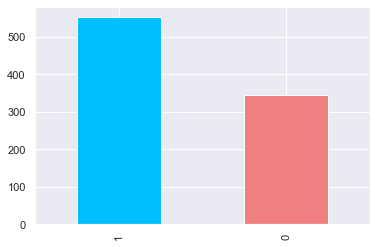

In [25]:
# check target variable distribution
df['Deceased'].value_counts().plot(kind='bar', color = [palette[1], palette[0]])

In [26]:
# check exact target distrubtion (in %)
print(round(df['Deceased'].value_counts()/df['Deceased'].count()*100, 2))

1    61.58
0    38.42
Name: Deceased, dtype: float64


In [27]:
# Check if family members live all in same city: MOSTLY TRUE
df[["Family_Case_ID", "City"]].groupby("Family_Case_ID").agg({"City": lambda x: len(x.unique())})["City"].value_counts()

1    664
2     10
Name: City, dtype: int64

In [28]:
# Check if family medical expenses are same for all family members: TRUE
# We will transform this feature to ExpensesPerPerson to standardize to patient level
df[(df.Family_Case_ID == df.Family_Case_ID) & (df.Medical_Expenses_Family != df.Medical_Expenses_Family )]

,Family_Case_ID,Severity,Gender,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
Patient_ID,,,,,,,,,,


In [29]:
# Family sizes
print(len(df.Family_Case_ID.unique()))
family_sizes = pd.Series(df.Family_Case_ID.value_counts())
family_sizes.value_counts()

674


1    530
2    101
3     24
4     10
7      3
6      3
5      3
Name: Family_Case_ID, dtype: int64

In [30]:
family_sizes

14502    7
20586    7
18593    7
23426    6
10262    6
        ..
5206     1
3535     1
23183    1
23178    1
21504    1
Name: Family_Case_ID, Length: 674, dtype: int64

In [31]:
# Check if patient with unique family case ID hase infected family members: TRUE
# We have to consider this when we create AvgSeverityOfOtherFamilyMembers and ProportionDeceasedOtherFamilyMembers 
familycase_singles = family_sizes[family_sizes == 1].index.values
print(df.loc[df.Family_Case_ID.isin(familycase_singles), "Parents or siblings infected"].value_counts())
print(df.loc[df.Family_Case_ID.isin(familycase_singles),  "Wife/Husband or children infected" ].value_counts())

0    501
1     18
2     10
3      1
Name: Parents or siblings infected, dtype: int64
0    468
1     55
2      6
4      1
Name: Wife/Husband or children infected, dtype: int64


In [32]:
# reset index to avoid issues in further joins
df.reset_index(inplace = True)

## 2.2 Encoding

We are one-hot encoding the categorical variables `Medical_Tent` and `City`.

In [33]:
# define columns with categorical variables
cat_columns = ['Medical_Tent', 'City', 'Gender']

# create new dataframe with numerical columns only
df_label_encoded = df[df.columns[~df.columns.isin(cat_columns)]].copy()

# will be used as final encoded dataframe
df_encoded = df.copy()

# For each categorical column we fit a label encoder, then one-hot encode that column, 
# and append the new columns to our dataframe

label_encoders = {}
ohe_encoders = {}

for col in cat_columns:
    #print("Encoding {}".format(col))
    new_le = preprocessing.LabelEncoder()
    df_label_encoded[col] = new_le.fit_transform(df[col])
    label_encoders[col] = new_le
    
    new_ohe = tent_ohe = preprocessing.OneHotEncoder()
    x = new_ohe.fit_transform(df[col].values.reshape(-1,1)).toarray()
    
    df_onehot = pd.DataFrame(x, columns = [col +str(label_encoders[col].classes_[i]) for i in range(x.shape[1])])
    df_encoded = pd.concat([df_encoded, df_onehot], axis=1)

In [34]:
df_encoded.head()

,Patient_ID,Family_Case_ID,Severity,Gender,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,...,Medical_TentE,Medical_TentF,Medical_TentG,Medical_TentT,Medical_Tentn/a,CityAlbuquerque,CitySanta Fe,CityTaos,GenderF,GenderM
0,1,4696,3,F,-1.0,0,0,225,n/a,Santa Fe,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2,21436,1,F,1966.0,0,1,1663,n/a,Albuquerque,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,3,7273,3,M,1982.0,0,0,221,n/a,Santa Fe,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,4,8226,3,M,1997.0,0,0,220,n/a,Santa Fe,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,5,19689,3,F,1994.0,0,0,222,n/a,Santa Fe,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [35]:
# change Gender to one binary column instead of two dummies 
df_encoded.drop('GenderF', axis = 1, inplace = True)
df_encoded.rename(columns = {'GenderM': 'Male'}, inplace = True)

## 2.3 Feature Engineering

Usnig the `Family_Case_ID`, we are deriving the `AvgSeverityOfOtherFamilyMembers` as well as the `ProportionDeceasedOtherFamilyMembers`. 

In [36]:
# Average Severity of other family members, excluding patient
df_encoded["AvgSeverityOfOtherFamilyMembers"] = [
    df_encoded[(df_encoded.Family_Case_ID == df_encoded.loc[pid, "Family_Case_ID"]) & (~df_encoded.index.isin([pid]))].Severity.mean() #family members
    if df_encoded.loc[pid, "Family_Case_ID"] not in familycase_singles
    else df_encoded.Severity.mean() # singles with infected family members
    if df_encoded.loc[pid, ["Parents or siblings infected","Wife/Husband or children infected"]].sum() > 0
    else 0 # singles with no infected family members                     
    for pid in df_encoded.index.values]


In [37]:
print(df_encoded["AvgSeverityOfOtherFamilyMembers"].value_counts())

0.000000    450
3.000000    165
1.000000    114
2.000000     85
2.316258     80
1.250000      4
Name: AvgSeverityOfOtherFamilyMembers, dtype: int64


In [38]:
df_encoded["family_size"] = [df_encoded.Family_Case_ID.value_counts()[fid] for fid in df_encoded.Family_Case_ID.values]

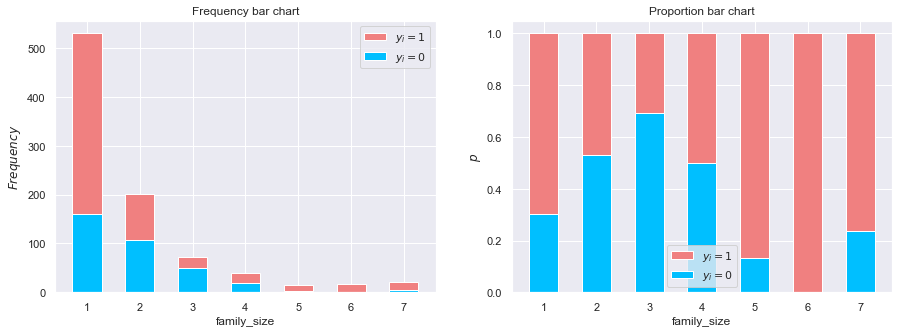

In [39]:
bar_charts_categorical(df_encoded, 'family_size','Deceased')

In [40]:
# set patient ID as index, as we don't need the feature but might want to keep the information
df_encoded.set_index('Patient_ID', inplace = True)

In [41]:
tent_severity = df_encoded[['Medical_Tent', 'Severity']].groupby('Medical_Tent').mean()
tent_severity.rename(columns = {'Severity': 'TentSeverity'}, inplace = True)

gender_severity = df_encoded[['Gender', 'Severity']].groupby('Gender').mean()
gender_severity.rename(columns = {'Severity': 'GenderSeverity'}, inplace = True)

city_severity = df_encoded[['City', 'Severity']].groupby('City').mean()
city_severity.rename(columns = {'Severity': 'CitySeverity'}, inplace = True)

In [42]:
df_encoded = pd.merge(df_encoded, tent_severity, on = 'Medical_Tent', how = 'left')
df_encoded = pd.merge(df_encoded, gender_severity, on = 'Gender', how = 'left')
df_encoded = pd.merge(df_encoded, city_severity, on = 'City', how = 'left')

In [43]:
df_encoded.columns.values

array(['Family_Case_ID', 'Severity', 'Gender', 'Birthday_year',
       'Parents or siblings infected',
       'Wife/Husband or children infected', 'Medical_Expenses_Family',
       'Medical_Tent', 'City', 'Deceased', 'Medical_TentA',
       'Medical_TentB', 'Medical_TentC', 'Medical_TentD', 'Medical_TentE',
       'Medical_TentF', 'Medical_TentG', 'Medical_TentT',
       'Medical_Tentn/a', 'CityAlbuquerque', 'CitySanta Fe', 'CityTaos',
       'Male', 'AvgSeverityOfOtherFamilyMembers', 'family_size',
       'TentSeverity', 'GenderSeverity', 'CitySeverity'], dtype=object)

In [44]:
# exclude the categorical columns
df_encoded = df_encoded[df_encoded.columns[~df_encoded.columns.isin(cat_columns)]]

## 2.4 Feature Selection
<font color='#FF0000'> Note for everyone: the feature selection should ideally be done with the model you're trying to optimize, not with the basic linear regression. This could lead to very high computational times. </font> <br>
### 2.4.1 Recursive Feature Elimination (RFE)

In [70]:
data = df_encoded.drop('Deceased', axis = 1)
target = df_encoded['Deceased']

We first need to define the optimal number of variables to keep. We do this by iterating through all possibilities and checking for which number of variables the score was the highest. 

In [71]:
#no of features
nof_list = np.arange(1, len(df_encoded.columns.values))            
high_score = 0
#Variable to store the optimum features
nof = 0           
score_list =[]
for n in range(len(nof_list)):
    # we are going to see in the next class this "train_test_split()"...
    X_train, X_test, y_train, y_test = train_test_split(data,target, test_size = 0.3, random_state = 0)
    
    model = LogisticRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 6
Score with 6 features: 0.844444


In [72]:
rfe = RFE(estimator = model, n_features_to_select = 4)
X_rfe = rfe.fit_transform(X = data, y = target) 

In [73]:
rfe_selected_features = pd.Series(rfe.support_, index = data.columns)
rfe_selected_features

Family_Case_ID                          False
Severity                                False
Birthday_year                           False
Parents or siblings infected            False
Wife/Husband or children infected       False
Medical_Expenses_Family                 False
Medical_TentA                           False
Medical_TentB                           False
Medical_TentC                           False
Medical_TentD                           False
Medical_TentE                           False
Medical_TentF                           False
Medical_TentG                           False
Medical_TentT                           False
Medical_Tentn/a                         False
CityAlbuquerque                         False
CitySanta Fe                            False
CityTaos                                False
Male                                     True
AvgSeverityOfOtherFamilyMembers         False
ProportionDeceasedOtherFamilyMembers     True
family_size                       

## 2.2 Step Forward Feature Selection

In [71]:
#!pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector

In [73]:
# Build RF classifier to use in feature selection
clf = LogisticRegression()

# Build step forward feature selection
nof_list = np.arange(1, len(df_encoded.columns.values)) 
high_score = 0 
nof = 0
score_list =[]

for x in range(len(nof_list)):
    sfs = SequentialFeatureSelector(clf,
               k_features=int(nof_list[x]),
               forward=True,
               floating=False,
               verbose=0,
               n_jobs = -1,
               scoring='accuracy',
               cv=5)
    sfs.fit(data, target)
    
    score = sfs.k_score_
    score_list.append([nof_list[x], score])
    
    if(score>high_score):
        high_score = score
        nof = nof_list[x]
        

In [74]:
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 7
Score with 7 features: 0.826207


In [75]:
sfs = SequentialFeatureSelector(clf,
           k_features=7,
           forward=True,
           floating=False,
           verbose=0,
           n_jobs = -1,
           scoring='accuracy',
           cv=5)
sfs.fit(data, target)

SequentialFeatureSelector(clone_estimator=True, cv=5,
                          estimator=LogisticRegression(C=1.0, class_weight=None,
                                                       dual=False,
                                                       fit_intercept=True,
                                                       intercept_scaling=1,
                                                       l1_ratio=None,
                                                       max_iter=100,
                                                       multi_class='auto',
                                                       n_jobs=None,
                                                       penalty='l2',
                                                       random_state=None,
                                                       solver='lbfgs',
                                                       tol=0.0001, verbose=0,
                                                       warm_start=False),

In [76]:
# check the features
sfs.k_feature_names_

('Severity',
 'Birthday_year',
 'Wife/Husband or children infected',
 'Medical_TentE',
 'Medical_TentF',
 'Male',
 'ProportionDeceasedOtherFamilyMembers')

# 3. Modeling

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

In [46]:
X = df_encoded.drop('Deceased', axis = 1)
y = df_encoded['Deceased']

In [137]:
X = df_encoded[['Severity',
 'Birthday_year',
 'Wife/Husband or children infected',
 'Medical_TentE',
 'Medical_TentF',
 'Male',
 'ProportionDeceasedOtherFamilyMembers']]
y = df_encoded['Deceased']

In [89]:
#Scaling
scale_type = None
if scale_type == "RobustScaler":
    robust = RobustScaler().fit(X)
    X = robust.transform(X)
elif scale_type == "MinMaxScaler":
    minmax = MinMaxScaler().fit(X)
    X = minmax.transform(X)
elif scale_type == "StandardScaler":
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

In [47]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X, y)

cross_val_score(gb, X, y, n_jobs=-1, cv=5, scoring="accuracy").mean()

0.8162383612662942

#### Hyperparameter tuning

In [51]:
import optuna
def objective(trial):

    loss = trial.suggest_categorical('loss', ["deviance", "exponential"])
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    subsample = trial.suggest_float('subsample', 0.1, 1)
    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'mse', 'mae'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100)
    max_depth = trial.suggest_int('max_depth', 2, 20) 
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0., 0.1)
    max_features = trial.suggest_float('max_features', 0.1, 1)
    max_leaf_nodes = trial.suggest_categorical('max_leaf_nodes', [10, 50, 100, None])
    warm_start = trial.suggest_categorical('warm_start', [True, False])
    n_iter_no_change = trial.suggest_categorical('n_iter_no_change', [5, 10, 15, 20, None])
    ccp_alpha = trial.suggest_float('ccp_alpha', 0, 0.1)
    

                                                                
    clf = GradientBoostingClassifier(loss=loss,
                      learning_rate=learning_rate,
                        n_estimators=n_estimators,
                        subsample=subsample,
                        criterion=criterion,
                        min_samples_split=min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth=max_depth,
                        min_impurity_decrease = min_impurity_decrease,
                        max_features=max_features, 
                        max_leaf_nodes=max_leaf_nodes,
                        warm_start=warm_start,
                        n_iter_no_change=n_iter_no_change,
                        ccp_alpha=ccp_alpha,
                        validation_fraction = 0.2,
                        random_state=1234
                       )
    #print(clf)
    score = cross_val_score(clf, X, y, n_jobs=-1, cv=5, scoring="accuracy")
    # print(score)
    score = score.mean()
    return score

is_training = True
if is_training:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=1000, n_jobs=-1)

[I 2020-05-10 22:20:36,526] Finished trial#4 with value: 0.6158100558659219 with parameters: {'loss': 'exponential', 'learning_rate': 0.06436835602325473, 'n_estimators': 374, 'subsample': 0.23148058070602742, 'criterion': 'mse', 'min_samples_split': 69, 'min_samples_leaf': 74, 'max_depth': 18, 'min_impurity_decrease': 0.05733885047656632, 'max_features': 0.5921934441964533, 'max_leaf_nodes': 100, 'warm_start': True, 'n_iter_no_change': 10, 'ccp_alpha': 0.03515725249017417}. Best is trial#4 with value: 0.6158100558659219.
[I 2020-05-10 22:20:36,697] Finished trial#0 with value: 0.6158100558659219 with parameters: {'loss': 'deviance', 'learning_rate': 0.04144949220822978, 'n_estimators': 75, 'subsample': 0.4324811257949268, 'criterion': 'friedman_mse', 'min_samples_split': 84, 'min_samples_leaf': 61, 'max_depth': 15, 'min_impurity_decrease': 0.013015065618733335, 'max_features': 0.2345285163109856, 'max_leaf_nodes': 10, 'warm_start': False, 'n_iter_no_change': 5, 'ccp_alpha': 0.08825795

In [52]:
# top scores
opt_scores = study.trials_dataframe()
opt_scores.sort_values("value", ascending=False).head(5)

,number,value,datetime_start,datetime_complete,params_ccp_alpha,params_criterion,params_learning_rate,params_loss,params_max_depth,params_max_features,params_max_leaf_nodes,params_min_impurity_decrease,params_min_samples_leaf,params_min_samples_split,params_n_estimators,params_n_iter_no_change,params_subsample,params_warm_start,state
734,734,0.830732,2020-05-10 22:27:59.780529,2020-05-10 22:28:04.792465,0.000211,friedman_mse,0.146915,exponential,18,0.652146,50.0,0.000105,16,43,150,20.0,0.696197,True,COMPLETE
833,833,0.830714,2020-05-10 22:29:16.600338,2020-05-10 22:29:24.897401,0.000126,friedman_mse,0.108983,deviance,17,0.630974,50.0,0.066966,25,34,207,20.0,0.831674,False,COMPLETE
727,727,0.829621,2020-05-10 22:27:56.332579,2020-05-10 22:28:00.371186,0.000027,friedman_mse,0.152201,exponential,19,0.663310,50.0,0.001952,12,43,164,20.0,0.659928,True,COMPLETE
785,785,0.829609,2020-05-10 22:28:37.498401,2020-05-10 22:28:44.294731,0.000097,friedman_mse,0.112606,deviance,16,0.599319,50.0,0.071401,28,26,200,20.0,0.809066,False,COMPLETE
775,775,0.829609,2020-05-10 22:28:29.987895,2020-05-10 22:28:36.599785,0.000061,friedman_mse,0.116200,deviance,15,0.595698,50.0,0.067530,25,26,196,20.0,0.775122,False,COMPLETE


I 2020-05-10 20:35:57,067] Finished trial#496 with value: 0.8429422718808194 with parameters: {'loss': 'exponential', 'learning_rate': 0.07196093140103406, 'n_estimators': 78, 'subsample': 0.8429621421323658, 'criterion': 'friedman_mse', 'min_samples_split': 32, 'min_samples_leaf': 9, 'max_depth': 8, 'min_impurity_decrease': 0.037019663384145814, 'max_features': 0.6730284062399909, 'max_leaf_nodes': None, 'warm_start': True, 'n_iter_no_change': 15, 'ccp_alpha': 0.010548535149120835}. Best is trial#496 with value: 0.8429422718808194.


In [53]:
gb = GradientBoostingClassifier(loss='exponential',
                      learning_rate=0.146915,
                        n_estimators=150,
                        subsample=0.696197,
                        criterion='friedman_mse',
                        min_samples_split=43,
                        min_samples_leaf =16,
                        max_depth=18,
                        min_impurity_decrease = 0.000105,
                        max_features=0.652146, 
                        max_leaf_nodes=50,
                        warm_start=True,
                        n_iter_no_change=20,
                        ccp_alpha=0.000211,
                        validation_fraction = 0.2,
                        random_state=1234)
gb.fit(X, y)

GradientBoostingClassifier(ccp_alpha=0.000211, criterion='friedman_mse',
                           init=None, learning_rate=0.146915,
                           loss='exponential', max_depth=18,
                           max_features=0.652146, max_leaf_nodes=50,
                           min_impurity_decrease=0.000105,
                           min_impurity_split=None, min_samples_leaf=16,
                           min_samples_split=43, min_weight_fraction_leaf=0.0,
                           n_estimators=150, n_iter_no_change=20,
                           presort='deprecated', random_state=1234,
                           subsample=0.696197, tol=0.0001,
                           validation_fraction=0.2, verbose=0, warm_start=True)

In [54]:
test_file = r'./test.csv'
new_data = pd.read_csv(test_file)

In [55]:
new_data.isna().sum()

Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                         82
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         311
City                                   0
dtype: int64

In [56]:
new_data.shape

(400, 10)

In [57]:
new_data['Name'].str.rsplit(' ', n=2, expand=True)[0].value_counts()

Mr.       234
Mrs.      127
Master     23
Miss       16
Name: 0, dtype: int64

In [58]:
new_data['Medical_Tent'] = new_data['Medical_Tent'].replace(np.nan, 'n/a', regex=True)

new_data['Birthday_year'] = new_data['Birthday_year'].replace(np.nan, -1)
new_data['Name'].str.rsplit(' ', n=2, expand=True)[0].value_counts()

gender = {'Mr.':"M",'Mrs.':"F",'Master':"M",'Miss':"F"}
new_data['Name'] = new_data['Name'].str.rsplit(' ', n=0, expand=True)
new_data['Name'] = [gender[item] for item in new_data['Name']]
new_data.rename(columns = {'Name':'Gender'},inplace=True)


In [59]:
# define columns with categorical variables
cat_columns = ['Medical_Tent', 'City', 'Gender']

# create new dataframe with numerical columns only
new_data_le = new_data[new_data.columns[~new_data.columns.isin(cat_columns)]].copy()

# will be used as final encoded dataframe
new_data_encoded = new_data.copy()

# For each categorical column we fit a label encoder, then one-hot encode that column, 
# and append the new columns to our dataframe

label_encoders = {}
ohe_encoders = {}

for col in cat_columns:
    #print("Encoding {}".format(col))
    new_le = preprocessing.LabelEncoder()
    new_data_le[col] = new_le.fit_transform(new_data[col])
    label_encoders[col] = new_le
    
    new_ohe = tent_ohe = preprocessing.OneHotEncoder()
    x = new_ohe.fit_transform(new_data[col].values.reshape(-1,1)).toarray()
    
    new_data_oh = pd.DataFrame(x, columns = [col +str(label_encoders[col].classes_[i]) for i in range(x.shape[1])])
    new_data_encoded = pd.concat([new_data_encoded, new_data_oh], axis=1)
    
# change Gender to one binary column instead of two dummies 
new_data_encoded.drop('GenderF', axis = 1, inplace = True)
new_data_encoded.rename(columns = {'GenderM': 'Male'}, inplace = True)

In [60]:
# Average Severity of other family members, excluding patient
new_data_encoded["AvgSeverityOfOtherFamilyMembers"] = [
    new_data_encoded[(new_data_encoded.Family_Case_ID == new_data_encoded.loc[pid, "Family_Case_ID"]) & (~new_data_encoded.index.isin([pid]))].Severity.mean() #family members
    if new_data_encoded.loc[pid, "Family_Case_ID"] not in familycase_singles
    else new_data_encoded.Severity.mean() # singles with infected family members
    if new_data_encoded.loc[pid, ["Parents or siblings infected","Wife/Husband or children infected"]].sum() > 0
    else 0 # singles with no infected family members                     
    for pid in new_data_encoded.index.values]


In [61]:
new_data_encoded["family_size"] = [new_data_encoded.Family_Case_ID.value_counts()[fid] for fid in new_data_encoded.Family_Case_ID.values]

In [62]:
new_data_encoded.set_index('Patient_ID', inplace = True)

In [63]:
tent_severity = new_data_encoded[['Medical_Tent', 'Severity']].groupby('Medical_Tent').mean()
tent_severity.rename(columns = {'Severity': 'TentSeverity'}, inplace = True)

gender_severity = new_data_encoded[['Gender', 'Severity']].groupby('Gender').mean()
gender_severity.rename(columns = {'Severity': 'GenderSeverity'}, inplace = True)

city_severity = new_data_encoded[['City', 'Severity']].groupby('City').mean()
city_severity.rename(columns = {'Severity': 'CitySeverity'}, inplace = True)

In [64]:
new_data_encoded = pd.merge(new_data_encoded, tent_severity, on = 'Medical_Tent', how = 'left')
new_data_encoded = pd.merge(new_data_encoded, gender_severity, on = 'Gender', how = 'left')
new_data_encoded = pd.merge(new_data_encoded, city_severity, on = 'City', how = 'left')

In [65]:
# exclude the categorical columns
new_data_encoded = new_data_encoded[new_data_encoded.columns[~new_data_encoded.columns.isin(cat_columns)]]

In [66]:
new_data_encoded.shape

(400, 23)

In [72]:
X.columns.values

array(['Family_Case_ID', 'Severity', 'Birthday_year',
       'Parents or siblings infected',
       'Wife/Husband or children infected', 'Medical_Expenses_Family',
       'Medical_TentA', 'Medical_TentB', 'Medical_TentC', 'Medical_TentD',
       'Medical_TentE', 'Medical_TentF', 'Medical_TentG', 'Medical_TentT',
       'Medical_Tentn/a', 'CityAlbuquerque', 'CitySanta Fe', 'CityTaos',
       'Male', 'AvgSeverityOfOtherFamilyMembers', 'family_size',
       'TentSeverity', 'GenderSeverity', 'CitySeverity'], dtype=object)

In [73]:
new_data_encoded.columns.values

array(['Family_Case_ID', 'Severity', 'Birthday_year',
       'Parents or siblings infected',
       'Wife/Husband or children infected', 'Medical_Expenses_Family',
       'Medical_TentA', 'Medical_TentB', 'Medical_TentC', 'Medical_TentD',
       'Medical_TentE', 'Medical_TentF', 'Medical_TentG',
       'Medical_Tentn/a', 'CityAlbuquerque', 'CitySanta Fe', 'CityTaos',
       'Male', 'AvgSeverityOfOtherFamilyMembers', 'family_size',
       'TentSeverity', 'GenderSeverity', 'CitySeverity'], dtype=object)

In [ ]:
# test data has no tent T.. 